In [1]:
import os
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Tensorflow version: {}'.format(tf.__version__))


Numpy version: 1.15.4
Pandas version: 0.23.4
Tensorflow version: 1.12.0


#Brainstorm for Kaggle:

* Blacklist some images from training. Remove duplicates. 'new_whale' images should be used as negatives in triplet loss. Augment dataset to balance each class with the same number of images.

* Explanation of the MAP5 scoring metric: https://www.kaggle.com/pestipeti/explanation-of-map5-scoring-metric

* Use multiple STNs to focus in on important features, let the network decide what is an important feature instead of feature engineering?

* Triple preprocessors: spatial frequency, spatial transformer, color space transformer.

* Preprocess images with a bilateral filter to preserve edges and reduce high frequency components of the image (like sea water)

* Feature Engineering: For each image, calculate Gradient location-orientation histogram (GLOH) features, write to .sift file. Feed both the image and the Gradient location-orientation histogram (GLOH) features into a neural network. 

* Feature Engineering: Or just shape context descriptor like a polar graph. Shapes will be shifted in theta-phase, so use a CNN with wrap-around edge conditions (only in the theta-dimension, not r).

* NO hand labeling anything! It's hard enough to capture the images and tag from real whales.

* Optimize hyperparameters, try hyperopt.

* Apply PCA to make a projection onto a colorspace that's fair and comparable for B&W and color images, somewhere in the middle. (lower priority)

* Find the notch or just projective-STN and start from the center of the image, create a log-polar image and run CNN classifier on that

# Dataset Anomalies

* test/0ec7b958d.jpg - two whales, same
* test/3cae6cc29.jpg - composites of two whale tails
* test/9aecef5dc.jpg - composite: tail, body, text
* test/c4e1fe45f.jpg - composite: two tails from different angles
* test/fbff4e7b1.jpg - composite: two tails from different angles
* train/0a5216ef5.jpg - two whales, same whale
* train/0c0bf8fb8.jpg - blurry
* train/0ce588f3d.jpg - front side markings of the fluke instead of the back - 
* train/0d0a1d2fb.jpg - poorly exposed image and tail is at an angle, hopefully not the only image in the class
* train/0d7bd80d3.jpg - occluded by spray
* train/0d25e3354.jpg - half tail? and noisy
* train/0d605d56a.jpg - wrong aspect ratio (squished), but nothing a bit of image processing can't fix
* train/0d37648f9.jpg - partial occlusion when fluke is underwater, top side of the tail instead of bottom
* train/0d757866b.jpg - occluded, almost half of the tail is in the water and not visible at all
* train/0db59bbec.jpg - occluded, half of the tail is in the water, text in the image
* train/0e6abdd05.jpg - illustration or sketch! handwriting in the image, as well

In [2]:
training_df = pd.read_csv('dataset/train.csv')
submissions_df = pd.read_csv('dataset/sample_submission.csv')

print('Training Dataframe Head')
training_df.head(10)


Training Dataframe Head


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [3]:
# Training data Id description
print(training_df['Id'].describe())

count         25361
unique         5005
top       new_whale
freq           9664
Name: Id, dtype: object


# Data Observations

## Challenges
* There are 9664 samples of class new_whale
* 5005 classes and 25361 data samples

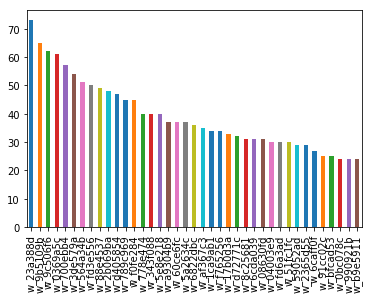

In [4]:
# Top-most frequent classes except for new_whale
training_df['Id'].value_counts()[1:40].plot(kind='bar')


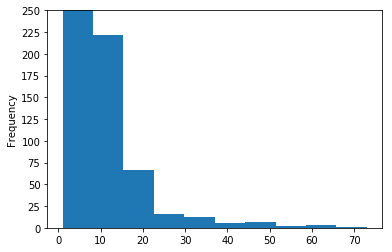

In [5]:
# Bottom-most frequent classes except for new_whale
Y_LIM = 250
Y_TICKS = 10
training_df['Id'].value_counts(ascending=True)[:-1].plot(
    kind='hist', 
    yticks=range(0, Y_LIM+1, int(Y_LIM/Y_TICKS)),
    ylim=[0, Y_LIM]
)

# Data Observations

## Histogram
* Over 4500 classes have only one training sample! (the y-limit is set at 250) Either data augmentation or input weighting would be necessary to balance the data set.
* With such little data, this is almost a template matching algorithm. Perhaps, a cue of these hand engineered features should be taken from this branch of computer vision:
	* Feature descriptors
	* Facial landmark detection
	* Fingerprint detection
* At least a spatial transformer network should be used to align the whale flukes for the convolution layers to then process.

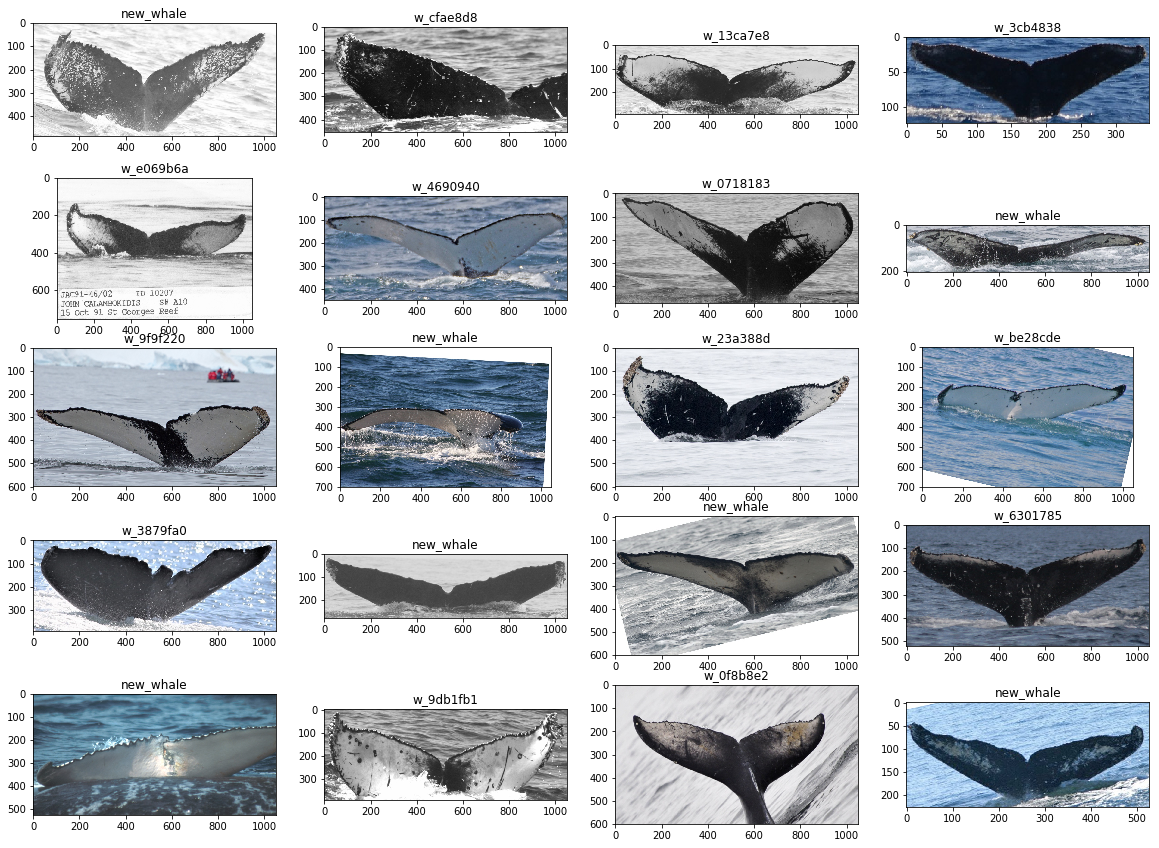

In [6]:
# Display a few random samples
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))
    for i in range(columns*rows):
        rand_i = np.random.randint(training_df['Id'].describe()['count'])
        image_path = df.loc[rand_i,'Image']
        image_id = df.loc[rand_i,'Id']
        img = cv2.cvtColor(
            cv2.imread(f'dataset/train/{image_path}'),
            cv2.COLOR_BGR2RGB
        )
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

display_samples(training_df, rows=5)

In [7]:
# There's a duplicate in the training set
print(training_df['Image'].loc[training_df['Image'] == '7f7a63b8a.jpg'])
print(training_df['Image'].loc[training_df['Image'] == '60a3f2422.jpg'])

12618    7f7a63b8a.jpg
Name: Image, dtype: object
9542    60a3f2422.jpg
Name: Image, dtype: object


In [7]:
# They're both of the same class
print('Label: {}'.format(training_df['Id'][12618]))
print('Label: {}'.format(training_df['Id'][9542]))


Label: w_7a8ce16
Label: w_7a8ce16


In [9]:
# This class has 6 images in the total class
print('Label has {} counts'.format(training_df.Id.value_counts()['w_7a8ce16']))
print('Label has {} counts'.format(training_df.Id.value_counts()['new_whale']))

Label has 6 counts
Label has 9664 counts


In [ ]:
# Read in dataset into Numpy arrays
from start.loader import ImageCachedDataset
from start.preprocessing import CropPreprocessor, ResizePreprocessor, ImageToTensorPreprocessor

dataset = ImageCachedDataset(
    dataset_path=r'dataset/train.csv',
    subdirectory='train',
    preprocessors=[
        CropPreprocessor(width=480, height=480, split=True),
        ResizePreprocessor(width=480, height=480, aspect_preserving=True),
        ImageToTensorPreprocessor()
    ]
)

data, labels = dataset.load({
    'verbosity': 250
})

[INFO] Retrieving dataset from dataframe:
                Image         Id
count           25361      25361
unique          25361       5005
top     a4985b42d.jpg  new_whale
freq                1       9664


[INFO] processed 80/25361 images


[INFO] processed 160/25361 images


[INFO] processed 240/25361 images


[INFO] processed 320/25361 images


[INFO] processed 400/25361 images


[INFO] processed 480/25361 images


[INFO] processed 560/25361 images


[INFO] processed 640/25361 images


[INFO] processed 720/25361 images


[INFO] processed 800/25361 images


[INFO] processed 880/25361 images


[INFO] processed 960/25361 images


[INFO] processed 1040/25361 images


[INFO] processed 1120/25361 images


[INFO] processed 1200/25361 images


[INFO] processed 1280/25361 images


[INFO] processed 1360/25361 images


[INFO] processed 1440/25361 images


[INFO] processed 1520/25361 images


[INFO] processed 1600/25361 images


[INFO] processed 1680/25361 images


[INFO] processed 1760/25361 images


[INFO] processed 1840/25361 images


[INFO] processed 1920/25361 images


[INFO] processed 2000/25361 images


[INFO] processed 2080/25361 images


[INFO] processed 2160/25361 images


[INFO] processed 2240/25361 images


[INFO] processed 2320/25361 images


[INFO] processed 2400/25361 images


[INFO] processed 2480/25361 images


[INFO] processed 2560/25361 images


[INFO] processed 2640/25361 images


[INFO] processed 2720/25361 images


[INFO] processed 2800/25361 images


[INFO] processed 2880/25361 images


[INFO] processed 2960/25361 images


[INFO] processed 3040/25361 images


[INFO] processed 3120/25361 images


[INFO] processed 3200/25361 images


[INFO] processed 3280/25361 images


[INFO] processed 3360/25361 images


[INFO] processed 3440/25361 images


[INFO] processed 3520/25361 images


[INFO] processed 3600/25361 images


[INFO] processed 3680/25361 images


[INFO] processed 3760/25361 images


[INFO] processed 3840/25361 images


[INFO] processed 3920/25361 images


[INFO] processed 4000/25361 images


[INFO] processed 4080/25361 images


[INFO] processed 4160/25361 images


[INFO] processed 4240/25361 images


[INFO] processed 4320/25361 images


[INFO] processed 4400/25361 images


[INFO] processed 4480/25361 images


[INFO] processed 4560/25361 images


KeyboardInterrupt: 